In [1]:
import numpy as np
import chaospy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

# parameters

In [7]:
# Total number of sample points
N = 2**13 # 8192

# interval of alpha grid
dalp = (0.98-0.02)/30   # 0.032

# range of alpha
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# dimension of inputs
dim = np.size(miu) # 4



# Test 1: Linear function

In [6]:
# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
sd = np.array([1,1.5,2,2.5])

a = [1,1,1,1]

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

## kucherenko_quantile function

In [217]:
def kucherenko_quantile(alp,N,miu,sd):
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    Q1_alp, Q2_alp = _nomalized_quantile_based_measures(N,M,dim,alp)
    
    return q1_alp, q2_alp, Q1_alp, Q2_alp


def _quantile_based_measures(N,M,dim,alp):
    # shape(1, 4, 1, 64)
    delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    q1_alp=np.zeros((len(alp),dim))
    q2_alp=np.zeros((len(alp),dim))
    
    qy_alp1 = _unconditional_q_Y(N,M,dim)
    qy_alp2 = _conditional_q_Y(N,M,dim,alp)
    
    for i in range(dim):
        for pp in range(len(alp)):
            delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
            q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
            q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2
            
    return q1_alp, q2_alp


def _nomalized_quantile_based_measures(N,M,dim,alp):
    # shape(1, 31)
    q1=np.zeros(len(alp))
    q2=np.zeros(len(alp))

    Q1_alp=np.zeros((len(alp),dim))
    Q2_alp=np.zeros((len(alp),dim))
    
    q1_alp, q2_alp = _quantile_based_measures(N,M,dim,alp)
    
    for pp in range(len(alp)):
        q1[pp]=np.sum(q1_alp[pp,:])
        q2[pp]=np.sum(q2_alp[pp,:])
        for i in range(dim):
            Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
            Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]
    
    return Q1_alp, Q2_alp


def _unconditional_q_Y(N,M,dim):
    A,B  = _get_samples(N, M, dim)
    # values of outputs
    Y1 = objfun(A)
    # reorder in ascending order
    y1 = np.sort(Y1)
    
    # q_Y(alp)
    q_index = (np.floor(alp*N)-1).astype(int)
    qy_alp1 = y1[q_index]
    
    return qy_alp1 


def _conditional_q_Y(N,M,dim,alp):
    A,B  = _get_samples(N, M, dim)
    
    # conditional sample matrix C,with shape(64, 4, 8192, 4)
    C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

    for i in range(dim):
        for j in range(M):
            C[j,i] = A
            C[j,i,:,i] = B[j, i]  
    # values of conditional outputs
    # shape(8192, 4, 8192, 1)
    Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
    
    # shape(1, 4, 31, 64)
    qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)
    
    for i in range(dim):
        for j in range(M):
            Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
            Y2[j,i].sort(axis=0)
            y2[j,i] = Y2[j,i] # reorder in ascending order
            for pp in range(len(alp)):
                qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)
    
    return qy_alp2


def _get_samples(N, M, dim):
    
    # A for unconditional sample
    A = np.zeros((N,dim))
    # B for conditional sample
    B = np.zeros((M,dim))
    X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
    X02 = cp.generate_samples(order=M, domain=dim, rule="S").T
    
    A = norm.ppf(X01,loc=miu, scale=sd)
    B = norm.ppf(X02,loc=miu, scale=sd)
    
    

    return A,B

In [218]:
q1_alp, q2_alp, Q1_alp, Q2_alp=kucherenko_quantile(alp,N,miu,sd)

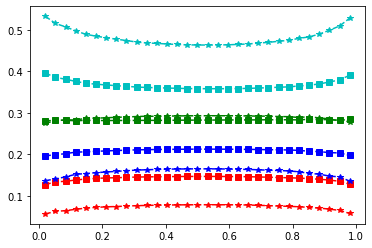

In [219]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

## solve q_Y(alp)

In [8]:
# number of conditional samples
M = 64

In [9]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [10]:
# alpha的sample
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

X01[0:10,:]

array([[0.5   , 0.5   , 0.5   , 0.5   ],
       [0.75  , 0.25  , 0.75  , 0.25  ],
       [0.25  , 0.75  , 0.25  , 0.75  ],
       [0.375 , 0.375 , 0.625 , 0.125 ],
       [0.875 , 0.875 , 0.125 , 0.625 ],
       [0.625 , 0.125 , 0.375 , 0.375 ],
       [0.125 , 0.625 , 0.875 , 0.875 ],
       [0.1875, 0.3125, 0.3125, 0.6875],
       [0.6875, 0.8125, 0.8125, 0.1875],
       [0.9375, 0.0625, 0.5625, 0.9375]])

In [11]:
# X1 = norm.ppf(X01)
# X2 = norm.ppf(X02)

# for i in range(dim):
#     A[:,i] = X1[:,i]*sd[i]+miu[i]
#     B[:,i] = X2[:,i]*sd[i]+miu[i]

In [12]:
# input的sample
A = norm.ppf(X01,loc=miu, scale=sd)
B = norm.ppf(X02,loc=miu, scale=sd)

NameError: name 'cov_1' is not defined

In [13]:
# values of outputs
Y1 = objfun(A)

In [14]:
# reorder in ascending order
y1 = np.sort(Y1)


In [15]:
# q_Y(alp)
q_index = (np.floor(alp*N)-1).astype(int)
qy_alp1 = y1[q_index]

## solve conditional q_Y(alp)

In [16]:
# conditional sample matrix C,with shape(64, 4, 8192, 4)
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i]  
         

In [17]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [18]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [19]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

## solve q_1(alp)  and  q_2(alp)

In [20]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [21]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [22]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [26]:
qy_alp1.shape

(31,)

## solve Q_1(alp)  and  Q_2(alp)

In [212]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [213]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]


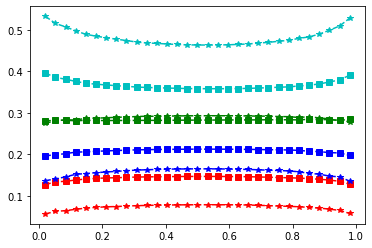

In [214]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')


# Test 2: $Y=x_1-x_2+x_3-x_4$

In [41]:
from scipy.stats import expon

In [68]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

In [69]:
a = [1,-1,1,-1]

def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

dist_type="Exponential"

# dimension of inputs
dim = np.size(a) # 4

In [70]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [71]:
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

In [72]:
# if dist_type=="Normal":
#     A = norm.ppf(X01,loc=miu, scale=sd)
#     B = norm.ppf(X02,loc=miu, scale=sd)
# elif dist_type=="Exponential":
#     A = expon.ppf(X01)
#     B = expon.ppf(X02)
    
A = expon.ppf(X01)

In [48]:
Y1 = objfun(A)

In [49]:
y1 = np.sort(Y1)

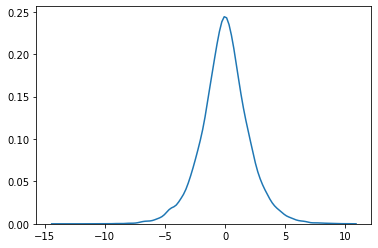

In [73]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

arr = y1

# # plot histogram
# plt.subplot(221)
# plt.hist(arr)

# obtain histogram data
# plt.subplot(222)
hist, bin_edges = np.histogram(arr)
# plt.plot(hist)

# fit histogram curve
# plt.subplot(223)
# sns.distplot(arr, kde=False, fit=stats.gamma, rug=True)
# plt.show()
sns.kdeplot(arr)

In [105]:
q_index = (np.floor(alp*N)-1).astype(int)
qy_alp1 = y1[q_index]

In [106]:
# conditional sample matrix C,with shape(64, 4, 8192, 4)
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [107]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [108]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [109]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [110]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [111]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [112]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [113]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [114]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]


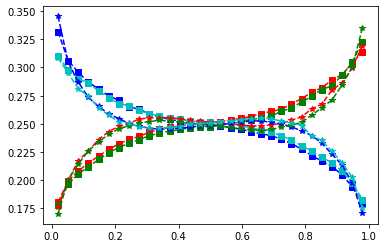

In [115]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

# Test 3: $Y=sin(x_1)+7(sin x_2)^2+0.1x_3^4sin(x_1)$

In [51]:
def objfun(x):

    result = np.sin(x[:,0]) + 7 * np.sin(x[:,1])**2 + 0.1 * x[:,2]**4*np.sin(x[:,0])
    
    return result

dim = 3

In [52]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

In [53]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [54]:
X01 = cp.generate_samples(order=N, domain=dim, rule="S").T
X02 = cp.generate_samples(order=M, domain=dim, rule="S").T

In [55]:
from scipy.stats import uniform

A = uniform.ppf(X01,loc=-np.pi,scale=2*np.pi)
B = uniform.ppf(X02,loc=-np.pi,scale=2*np.pi)

In [56]:
Y1 = objfun(A)

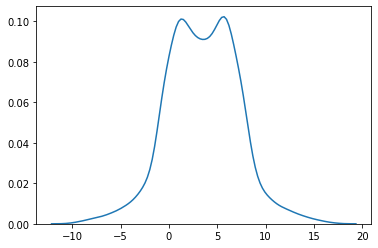

In [67]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

arr = Y1

# # plot histogram
# plt.subplot(221)
# plt.hist(arr)

# obtain histogram data
# plt.subplot(222)
hist, bin_edges = np.histogram(arr)
# plt.plot(hist)

# fit histogram curve
# # plt.subplot(223)
# sns.distplot(arr, kde=False,  rug=False)
# plt.show()
# plt.plot(arr)
sns.kdeplot(arr)

In [149]:
y1 = np.sort(Y1)

In [150]:
q_index = (np.floor(alp*N)-1).astype(int)


In [151]:
qy_alp1 = y1[q_index]

In [152]:
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [153]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [154]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [155]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [156]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [157]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [158]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [159]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [160]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]

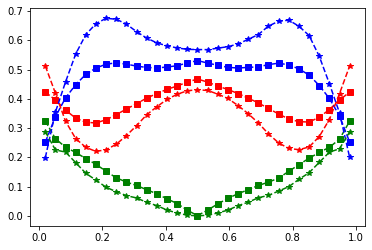

In [162]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--')

# Test 4: $Y=x_1 x_3+x_2 x_4$

In [74]:
miu = np.array([0, 0, 250, 400])

cov = np.array(
    [
        [16, 2.4, 0, 0],
        [2.4, 4, 0, 0],
        [0, 0, 40000, -18000],
        [0, 0, -18000, 90000],
    ],
)

dim = np.size(miu)
np.size(miu)

4

In [75]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

# mean for normal distribution
miu = np.array([1,3,5,7])

# standard deviation for normal distribution
# sd = np.array([1,1.5,2,2.5])
cov = np.array(
    [
        [1, 0, 0, 0],
        [0, 2.25, 0, 0],
        [0, 0, 4, 0],
        [0, 0, 0, 6.25],
    ],
)

# objective function
a = [1,1,1,1]
def objfun(x):
    result = a[0]*x[:,0]+a[1]*x[:,1]+a[2]*x[:,2]+a[3]*x[:,3]
    return result

# dimension of inputs
dim = np.size(miu) # 4

# distribution type
dist_type="Normal"

skip=0

In [76]:
def objfun(x):

    result = x[:,0]*x[:,2]+x[:,1]*x[:,3]
    
    return result


In [77]:
# Total number of sample points
N = 2**13 # 8192

# range of alpha
dalp = (0.98-0.02)/30   # 0.032
alp = np.arange(0.02, 0.98+dalp, dalp) 

# number of conditional samples
M = 64

In [78]:
A = np.zeros((N,dim))
B = np.zeros((M,dim))

In [79]:
# get_uniform_base_draws
X001 = cp.generate_samples(order=N+skip, domain=dim, rule="S").T
X002 = cp.generate_samples(order=M+skip, domain=dim, rule="S").T

X01 = X001[skip:, :dim]
X02= X002[skip:, :dim]


In [80]:
# uniform_to_multivariate_normal
X1 = norm.ppf(X01)
X2 = norm.ppf(X02)

cholesky = np.linalg.cholesky(cov)

A = miu + cholesky.dot(X1.T).T
B = miu + cholesky.dot(X2.T).T


In [28]:
# import seaborn as sns; 
# sns.set()
# sns.jointplot(x=A[:,0],
#               y=A[:,1], 
#               kind="kde", 
#               space=0);

In [352]:
# sns.set()
# sns.jointplot(x=B[:,0],
#               y=B[:,1], 
#               kind="kde", 
#               space=0);

In [321]:
# hist, bin_edges = np.histogram(A)
# width = (bin_edges[1] - bin_edges[0]) * 0.8
# plt.bar(bin_edges[1:], hist/max(hist), width=width, color='#5B9BD5')

# cdf = np.cumsum(hist/sum(hist))
# plt.plot(bin_edges[1:], cdf, '-*', color='#ED7D31')


# plt.grid()

In [322]:
# from scipy import stats
# Y1 = objfun(A)
# Y1

# hist, bin_edges = np.histogram(Y1)
# width = (bin_edges[1] - bin_edges[0]) * 0.8
# plt.bar(bin_edges[1:], hist/max(hist), width=width, color='#5B9BD5')

# cdf = np.cumsum(hist/sum(hist))
# plt.plot(bin_edges[1:], cdf, '-*', color='#ED7D31')


# plt.grid()

In [81]:
Y1 = objfun(A)
y1 = np.sort(Y1)

In [54]:
q_index = (np.floor(alp*N)-1).astype(int)

In [55]:
qy_alp1 = y1[q_index]

In [56]:
C = np.array([[np.zeros((N,dim)) for x in range(dim)] for z in range(M)],dtype=np.float64)

for i in range(dim):
    for j in range(M):
        C[j,i] = A
        C[j,i,:,i] = B[j, i] 

In [57]:
# values of conditional outputs
# shape(8192, 4, 8192, 1)
Y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)
y2=np.array([[np.zeros((N,1)) for x in range(dim)] for z in range(N)],dtype=np.float64)

In [58]:
# shape(1, 4, 31, 64)
qy_alp2=np.array([[np.zeros((len(alp),M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [59]:
for i in range(dim):
    for j in range(M):
        Y2[j,i] = np.vstack(objfun(C[j,i]))  # values of conditional outputs
        Y2[j,i].sort(axis=0)
        y2[j,i] = Y2[j,i] # reorder in ascending order
        for pp in range(len(alp)):
            qy_alp2[0,i,pp,j]=y2[j,i][(np.floor(alp[pp]*N)-1).astype(int)] # conditioanl q_Y(alp)

In [60]:
# shape(1, 4, 1, 64)
delt=np.array([[np.zeros((1,M)) for x in range(dim)] for z in range(1)],dtype=np.float64)

In [61]:
q1_alp=np.zeros((len(alp),dim))
q2_alp=np.zeros((len(alp),dim))

In [62]:
for i in range(dim):
    for pp in range(len(alp)):
        delt[0,i]=qy_alp2[0,i,pp,:] - qy_alp1[pp]  # delt
        q1_alp[pp,i]=np.mean(np.absolute(delt[0,i]))  # |delt|
        q2_alp[pp,i]=np.mean(delt[0,i]**2)  # (delt)^2

In [63]:
# shape(1, 31)
q1=np.zeros(len(alp))
q2=np.zeros(len(alp))


Q1_alp=np.zeros((len(alp),dim))
Q2_alp=np.zeros((len(alp),dim))

In [64]:
for pp in range(len(alp)):
    q1[pp]=np.sum(q1_alp[pp,:])
    q2[pp]=np.sum(q2_alp[pp,:])
    for i in range(dim):
        Q1_alp[pp,i]=q1_alp[pp,i]/q1[pp]
        Q2_alp[pp,i]=q2_alp[pp,i]/q2[pp]

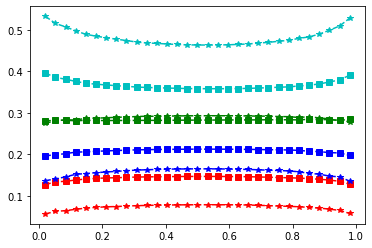

In [65]:
plt.plot(alp,Q1_alp[:,0],'rs--',alp,Q1_alp[:,1],'bs--',alp,Q1_alp[:,2],'gs--',alp,Q1_alp[:,3],'cs--')

plt.plot(alp,Q2_alp[:,0],'r*--',alp,Q2_alp[:,1],'b*--',alp,Q2_alp[:,2],'g*--',alp,Q2_alp[:,3],'c*--')

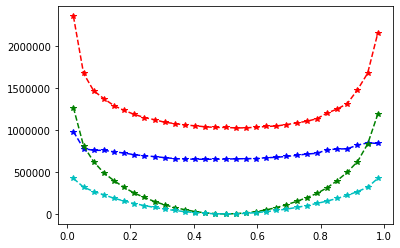

In [44]:
# plt.plot(alp, q1_alp[:,0],'rs--',alp,q1_alp[:,1],'bs--',alp,q1_alp[:,2],'gs--',alp,q1_alp[:,3],'cs--')

plt.plot(alp,q2_alp[:,0],'r*--',alp,q2_alp[:,1],'b*--',alp,q2_alp[:,2],'g*--',alp,q2_alp[:,3],'c*--')